In [1]:
from IPython import get_ipython
from IPython.display import display

In [2]:
!pip install tensorflow
!pip install keras
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.4/744.4 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detec

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
from google.colab import files
import os
import pathlib

In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/CollabData/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download samuelcortinhas/sports-balls-multiclass-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification
License(s): CC0-1.0
 97% 388M/401M [00:02<00:00, 132MB/s]
100% 401M/401M [00:03<00:00, 137MB/s]


In [8]:
! unzip sports-balls-multiclass-image-classification.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: train/cricket_ball/cricket_ball_182.jpg  
  inflating: train/cricket_ball/cricket_ball_183.jpg  
  inflating: train/cricket_ball/cricket_ball_185.jpg  
  inflating: train/cricket_ball/cricket_ball_186.jpg  
  inflating: train/cricket_ball/cricket_ball_187.jpg  
  inflating: train/cricket_ball/cricket_ball_189.jpg  
  inflating: train/cricket_ball/cricket_ball_19.jpg  
  inflating: train/cricket_ball/cricket_ball_190.jpg  
  inflating: train/cricket_ball/cricket_ball_191.jpg  
  inflating: train/cricket_ball/cricket_ball_192.jpg  
  inflating: train/cricket_ball/cricket_ball_195.jpg  
  inflating: train/cricket_ball/cricket_ball_196.jpg  
  inflating: train/cricket_ball/cricket_ball_199.jpg  
  inflating: train/cricket_ball/cricket_ball_200.jpg  
  inflating: train/cricket_ball/cricket_ball_201.jpg  
  inflating: train/cricket_ball/cricket_ball_202.jpg  
  inflating: train/cricket_ball/cricket_ball_209.jpg  
  infla

In [9]:
# Create an ImageDataGenerator for preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training and testing datasets
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7328 images belonging to 15 classes.
Found 1841 images belonging to 15 classes.


In [10]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Determine the number of classes (sports ball types) in your dataset
num_classes = 15

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(num_classes, activation='softmax')(x) # num_classes is now defined

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.5138 - loss: 1.6358 - val_accuracy: 0.7599 - val_loss: 0.7554
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.7859 - loss: 0.7177 - val_accuracy: 0.7922 - val_loss: 0.6512
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.8303 - loss: 0.5544 - val_accuracy: 0.8015 - val_loss: 0.6257
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.8582 - loss: 0.4745 - val_accuracy: 0.8087 - val_loss: 0.5891
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.8675 - loss: 0.4327 - val_accuracy: 0.8147 - val_loss: 0.5794
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.8830 - loss: 0.3780 - val_accuracy: 0.8163 - val_loss: 0.5705
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.8903 - loss: 0.3531 - val_accuracy: 0.8076 - val_loss: 0.6038
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.9081 - loss: 0.3275 - val_accu

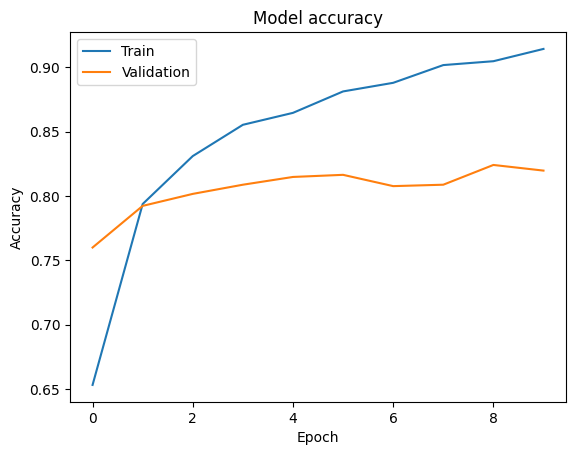

In [12]:
# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model
model.save('sports_ball_classifier.h5')

In [13]:
def predict_image(img_path, class_names):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.

    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction)

    # Map predicted_class_index to the corresponding sports ball type
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name  # Return the class name

In [14]:
class_names = list(train_generator.class_indices.keys())

In [17]:
    uploaded = files.upload()

    for fn in uploaded.keys():
      # predicting images
      path = fn
      img = image.load_img(path, target_size=(224,224))
      predicted_class_name = predict_image(path, class_names) # Call the function here
      print(f"The predicted class for {fn} is: {predicted_class_name}")

Saving premium_photo-1684888644155-025be2f3ea7c.jpg to premium_photo-1684888644155-025be2f3ea7c.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
The predicted class for premium_photo-1684888644155-025be2f3ea7c.jpg is: football
